In [1]:
!kaggle competitions download -c tutors-lessons-prices

In [2]:
!unzip tutors-lessons-prices.zip

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from re import search, findall, sub

## Исследование и анализ датасета

In [4]:
random_state = 42
np.random.seed(random_state)

In [5]:
# Загрузка данных
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

In [6]:
train.head()

,Unnamed: 0,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,...,status,experience,Desc_Education_5,Desc_Education_6,Education_5,Education_6,Ученая степень 2,Ученое звание 2,categories,mean_price
0,0,matematika,Репетитор по математике Емельянова Марина Вла...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",5.0,2,Репетитор не предоставил о себе дополн...,NaN,Томский государственный университет им. В.В. ...,"Год окончания: 1990, Факультет: механико-мате...",...,Университетский преподаватель,31 год,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667
1,1,matematika,Репетитор по математике Назарова Анастасия Ан...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",4.0,7,Репетитор не предоставил о себе дополн...,NaN,Вологодский государственный педагогический ун...,"Год окончания: 2017, Факультет: факультет при...",...,Школьный преподаватель,8 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",11.666667
2,2,informatika,Репетитор по информатике Мотроненко Инна Конст...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Выезд за город: Балашиха-1, Балашиха-2...",Московская Школа (учитель ...,Московский городской педагогический университет,"Год окончания: 2008, Факультет: Математически...",...,Школьный преподаватель,11 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",23.333333
3,3,matematika,Репетитор по математике Логинова Елизавета Ал...,"['Школьная программа', 'Математический анализ'...",4.0,19,"Здравствуйте! Меня зовут Елизавета, о...",NaN,Санкт-Петербургский государственный университет,"Год окончания: 2021, Факультет: физический фа...",...,Частный преподаватель,5 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 1 по 4 класс', 'Школьники с 5 по...",0.116667
4,4,matematika,Репетитор по математике Харланов Олег Викторо...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Целеустремленный, ориентирован на резу...",преподавателем ...,Приазовский государственный технический униве...,"Год окончания: 2005, Факультет: Энергетически...",...,Частный преподаватель,19 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4548 non-null   int64  
 1   предмет           4548 non-null   object 
 2   ФИО               4548 non-null   object 
 3   tutor_head_tags   4548 non-null   object 
 4   tutor_rating      3959 non-null   float64
 5   tutor_reviews     4548 non-null   int64  
 6   description       4547 non-null   object 
 7   experience_desc   2171 non-null   object 
 8   Education_1       4548 non-null   object 
 9   Desc_Education_1  4472 non-null   object 
 10  Education_2       781 non-null    object 
 11  Desc_Education_2  777 non-null    object 
 12  Education_3       106 non-null    object 
 13  Desc_Education_3  105 non-null    object 
 14  Education_4       16 non-null     object 
 15  Desc_Education_4  16 non-null     object 
 16  Ученая степень 1  76 non-null     object 


Датасет содержит 4548 записей и 28 столбцов различной природы. 

Среди данных присутствуют как количественные показатели (например, оценки преподавателей, количество отзывов), так и качественные (описательные поля вроде предметов преподавания, образовательных учреждений, уровня подготовки учеников). 

Некоторые столбцы содержат пропуски. Например, в столбце tutor_rating присутствует лишь 3959 ненулевых значений из 4548 возможных. Это значит, что около 13% записей имеют пустые значения по этому параметру.

Для дальнейшей обработки потребуется работа с пропущенными значениями и правильная обработка качественных полей (категорий).

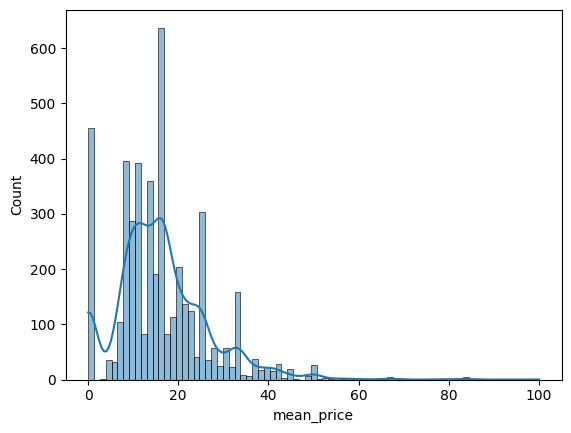

In [8]:
# График распределения средней стоимости услуг репетиров
sns.histplot(train['mean_price'], kde=True)
plt.show()

График показывает, что большинство репетиторов предлагают свои услуги по цене около 20 рублей за минуту, что является наиболее популярной ценовой категорией. Цены выше 50 рублей встречаются редко.

## Предпобработка данных

In [9]:
# Преобразование значений колонки experience к количественному типу
def prepare_experience(value: str) -> int:
    if isinstance(value, str): 
        return float(search(r"\d+", value).group(0))
    return value

train["experience"] = train["experience"].apply(prepare_experience)

In [10]:
# Заполнение пропусков в колонке description
train["description"] = train["description"].fillna("Репетитор не предоставил о себе дополнительных сведений")

In [11]:
def divide_list(value):
    """Функция для рпреобразования строки в список"""
    if isinstance(value, str):
        return findall(r"\'([\w ]+)\'", value)
    if value is None:
        return []
    return value

def explode_column_to_binary_columns(df, column_name):
    """
    Функция создает новые колонки на основе элементов списка,
    присутствующего в указанной колонке DataFrame.

    :param df: исходный DataFrame
    :param column_name: название колонки, содержащей списки
    :return: обновленный DataFrame с дополнительными колонками
    """
    # Получаем уникальные элементы из списков
    unique_elements = set()
    for element_list in df[column_name]:
        if isinstance(element_list, list):
            unique_elements.update(element_list)

    # Добавляем новые колонки для каждого уникального элемента
    for element in sorted(unique_elements):
        tag_name = sub(r"\s", "_", f"{column_name}_{element}")
        df[tag_name] = df[column_name].apply(
            lambda x: element in x if isinstance(x, list) else False)
    return df

In [12]:
# Обработка колонок спискового типа
list_features = ["tutor_head_tags", "categories"]
for f in list_features:
    train[f] = train[f].apply(divide_list)
    train = explode_column_to_binary_columns(train, f)
    train.drop(columns=[f], inplace=True)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 54 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Unnamed: 0                                                 4548 non-null   int64  
 1   предмет                                                    4548 non-null   object 
 2   ФИО                                                        4548 non-null   object 
 3   tutor_rating                                               3959 non-null   float64
 4   tutor_reviews                                              4548 non-null   int64  
 5   description                                                4548 non-null   object 
 6   experience_desc                                            2171 non-null   object 
 7   Education_1                                                4548 non-null   object 
 8   Desc_Edu

In [14]:
train.head()

,Unnamed: 0,предмет,ФИО,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,Education_2,...,categories_Дошкольники_в_паре,categories_Дошкольники_группа,categories_Студенты_университетов,categories_Студенты_университетов_в_паре,categories_Школьники_с_1_по_4_класс,categories_Школьники_с_1_по_4_класс_в_паре,categories_Школьники_с_1_по_4_класс_группа,categories_Школьники_с_5_по_9_класс,categories_Школьники_с_5_по_9_класс_в_паре,categories_Школьники_с_5_по_9_класс_группа
0,0,matematika,Репетитор по математике Емельянова Марина Вла...,5.0,2,Репетитор не предоставил о себе дополн...,NaN,Томский государственный университет им. В.В. ...,"Год окончания: 1990, Факультет: механико-мате...",NaN,...,False,False,False,False,False,False,False,True,False,False
1,1,matematika,Репетитор по математике Назарова Анастасия Ан...,4.0,7,Репетитор не предоставил о себе дополн...,NaN,Вологодский государственный педагогический ун...,"Год окончания: 2017, Факультет: факультет при...",Череповецкий государственный университет,...,False,False,False,False,False,False,False,True,False,False
2,2,informatika,Репетитор по информатике Мотроненко Инна Конст...,0.0,0,"Выезд за город: Балашиха-1, Балашиха-2...",Московская Школа (учитель ...,Московский городской педагогический университет,"Год окончания: 2008, Факультет: Математически...",Московский городской педагогический университ...,...,False,False,False,False,False,False,False,True,False,False
3,3,matematika,Репетитор по математике Логинова Елизавета Ал...,4.0,19,"Здравствуйте! Меня зовут Елизавета, о...",NaN,Санкт-Петербургский государственный университет,"Год окончания: 2021, Факультет: физический фа...",NaN,...,False,False,True,False,True,False,False,True,False,False
4,4,matematika,Репетитор по математике Харланов Олег Викторо...,0.0,0,"Целеустремленный, ориентирован на резу...",преподавателем ...,Приазовский государственный технический униве...,"Год окончания: 2005, Факультет: Энергетически...",NaN,...,False,False,False,False,False,False,False,True,False,False


In [15]:
categorical_features = [
    "предмет",
    "description", 
    "experience_desc", 
    "Education_1",
    "Desc_Education_1",
    "Education_2",
    "Desc_Education_2",
    "Education_3",
    "Desc_Education_3",
    "Education_4",
    "Desc_Education_4",
    "Ученая степень 1",
    "Ученое звание 1",
    "status",
    "Desc_Education_5",
    "Desc_Education_6",
    "Education_5",
    "Education_6",
    "Ученая степень 2",
    "Ученое звание 2"
]
numeric_features = ["tutor_rating", "tutor_reviews", "experience"]

In [16]:
# Заполнение пропусков в категориальных параметрах
for f in categorical_features:
    train[f] = train[f].fillna("Не указано")

In [17]:
# Удаляем лишние и целевую колонки
deleted_columns = ["Unnamed: 0", "ФИО", "mean_price"]
X = train.drop(columns=deleted_columns)
# Определение целевой переменной
y = train['mean_price']

In [18]:
# Список колонок, для которых не будет применяться processor:
passed_columns = list(set(X.columns) - set(categorical_features) - set(numeric_features) - set(list_features))
preprocessor = ColumnTransformer(
    transformers=[
        # Заполнение пропусков в количественных параметрах:
        ('num', SimpleImputer(strategy='median'), numeric_features),
        # Кодирование категориальных признаков:
        ('cat', TargetEncoder(), categorical_features),
        ('pass', 'passthrough', passed_columns)
    ])

X_processed = preprocessor.fit_transform(X, y)
feature_names = preprocessor.get_feature_names_out()
X_processed = pd.DataFrame(X_processed, columns=feature_names)

In [19]:
X_processed.head()

,num__tutor_rating,num__tutor_reviews,num__experience,cat__предмет,cat__description,cat__experience_desc,cat__Education_1,cat__Desc_Education_1,cat__Education_2,cat__Desc_Education_2,...,pass__categories_Дошкольники,pass__tutor_head_tags_Дифференциальные_уравнения,pass__categories_Школьники_с_1_по_4_класс_в_паре,pass__categories_Дошкольники_группа,pass__tutor_head_tags_Математический_анализ,pass__categories_Взрослые_кроме_абитуриентов_и_студентов_группа,pass__tutor_head_tags_Mathematik_auf_Deutsch,pass__tutor_head_tags_Математическая_логика,pass__categories_Школьники_с_1_по_4_класс_группа,pass__tutor_head_tags_Elementary_Mathematics_in_English
0,5.0,2.0,31.0,15.635372,13.133846,14.053426,16.658468,16.258933,15.626638,15.627742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,7.0,8.0,15.635372,13.133846,14.053426,14.951730,15.608391,15.608391,15.608391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,11.0,18.600144,17.849614,17.849614,17.082336,17.918275,17.849614,17.849614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,19.0,5.0,15.635372,14.105638,14.053426,17.530324,14.105638,15.626638,15.627742,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,19.0,15.635372,16.258933,16.258933,16.258933,16.258933,15.626638,15.627742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 51 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   num__tutor_rating                                                4548 non-null   float64
 1   num__tutor_reviews                                               4548 non-null   float64
 2   num__experience                                                  4548 non-null   float64
 3   cat__предмет                                                     4548 non-null   float64
 4   cat__description                                                 4548 non-null   float64
 5   cat__experience_desc                                             4548 non-null   float64
 6   cat__Education_1                                                 4548 non-null   float64
 7   cat__Desc_Education_1                     

## Подбор признаков и обучение модели

Создаем базовую модель линейной регрессии и оцениваем её качество.

In [21]:
# Масштабирование признаков (стандартизация)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

In [22]:
# Предварительное разделение на обучение и проверку (для локальной оценки)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

In [23]:
# Обучение базовых моделей линейной регрессии
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1, random_state=random_state),
    "Lasso Regression": Lasso(alpha=1, random_state=random_state)
}

for name, model in models.items():
    print(f"\nМодель: {name}\n")
    # Обучаем модель
    model.fit(X_train, y_train)

    # Оцениваем качество на проверочной части
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"Средняя квадратичная ошибка (MSE): {mse:.4f}")
    print(f"Коэффициент детерминации (R^2): {r2:.4f}")


Модель: Linear Regression

Средняя квадратичная ошибка (MSE): 16.3769
Коэффициент детерминации (R^2): 0.8612

Модель: Ridge Regression

Средняя квадратичная ошибка (MSE): 16.3721
Коэффициент детерминации (R^2): 0.8612

Модель: Lasso Regression

Средняя квадратичная ошибка (MSE): 17.8787
Коэффициент детерминации (R^2): 0.8485


Лучшая модель — Ridge Regression, так как она имеет наименьший MSE.

Разница между Linear и Ridge очень мала, но технически Ridge выигрывает.

In [24]:
# Настройка гиперпараметров для Ridge
param_grid_ridge = {"alpha": [0.01, 0.1, 1, 10]}
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring="neg_mean_squared_error")
grid_search_ridge.fit(X_train, y_train)
best_alpha_ridge = grid_search_ridge.best_params_["alpha"]
print(f"\nЛучшая альфа для Ridge: {best_alpha_ridge}")


Лучшая альфа для Ridge: 10


In [25]:
# Настройка гиперпараметров для Lasso
param_grid_lasso = {"alpha": [0.01, 0.1, 1, 10], "max_iter": [10000]}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring="neg_mean_squared_error")
grid_search_lasso.fit(X_train, y_train)
best_alpha_lasso = grid_search_lasso.best_params_["alpha"]
print(f"\nЛучшая альфа для Lasso: {best_alpha_lasso}")


Лучшая альфа для Lasso: 0.1


In [26]:
# Повторное обучение лучших моделей с подобранными параметрами
final_models = {
    "Final Ridge": Ridge(alpha=best_alpha_ridge),
    "Final Lasso": Lasso(alpha=best_alpha_lasso)
}

for name, model in final_models.items():
    print(f"\nФинальная модель: {name}\n")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"Модель {name}: MSE={mse:.4f}, R^2={r2:.4f}")


Финальная модель: Final Ridge

Модель Final Ridge: MSE=16.3602, R^2=0.8613

Финальная модель: Final Lasso

Модель Final Lasso: MSE=15.9807, R^2=0.8646


Линейная регрессия демонстрирует достаточно хороший показатель R^2, близкий к 1, однако значение MSE является относительно высоким среди представленных моделей.

Регуляризация Ridge незначительно улучшает значения показателей по сравнению с линейной регрессией. Однако разница минимальна.

Регуляризация Lasso обеспечивает наилучшие результаты среди всех трех моделей. Она имеет наименьшую ошибку (MSE) и лучший коэффициент детерминации (R^22), приближенный к 1.

Финальная модель Lasso оказалась наиболее точной и предпочтительной.

## Финальное предсказание

In [27]:
# Предобработка тестовых данных
test["experience"] = test["experience"].apply(prepare_experience)
test["description"] = test["description"].fillna("Репетитор не предоставил о себе дополнительных сведений")

for f in list_features:
    test[f] = test[f].apply(divide_list)
    test = explode_column_to_binary_columns(test, f)
    test.drop(columns=[f], inplace=True)

for f in categorical_features:
    test[f] = test[f].fillna("Не указано")

In [29]:
# Удаляем целевые и ненужные колонки из train, чтобы получить шаблон
X_train_full = train.drop(columns=deleted_columns)

# Получаем список всех колонок, которые были после обработки
expected_columns = X_train_full.columns.tolist()

# Добавляем недостающие колонки в test как нули
for col in expected_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Удаляем лишние колонки (если есть)
X_test = X_test[expected_columns]

In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 51 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   предмет                                                    1516 non-null   object 
 1   tutor_rating                                               1516 non-null   int64  
 2   tutor_reviews                                              1516 non-null   int64  
 3   description                                                1516 non-null   object 
 4   experience_desc                                            1516 non-null   object 
 5   Education_1                                                1516 non-null   object 
 6   Desc_Education_1                                           1516 non-null   object 
 7   Education_2                                                1516 non-null   object 
 8   Desc_Edu

In [35]:
X_test_processed = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names)

In [36]:
X_test_scaled = scaler.transform(X_test_processed)

In [42]:
# Используем лучшую модель для предсказания на тестовом наборе
best_model = Lasso(alpha=best_alpha_lasso)
best_model.fit(X_scaled, y)
predictions = best_model.predict(X_test_scaled)

In [46]:
# Сохранение результата
result = pd.DataFrame({"mean_price": predictions})

result.to_csv("prediction_results.csv", index=True, index_label="index")

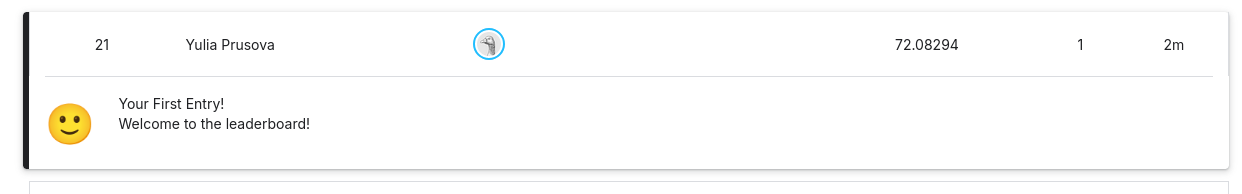